In [7]:
import pandas as pd

DATA_PATH = '../data/'

s49 = pd.read_csv(DATA_PATH + "station_49.csv")
s80 = pd.read_csv(DATA_PATH + "station_80.csv")
s40 = pd.read_csv(DATA_PATH + "station_40.csv")
s63 = pd.read_csv(DATA_PATH + "station_63.csv")

In [8]:
s49.iloc[:,11:-1]

,W_11,W_12,W_13,W_14,W_15,W_16,W_17,W_18
0,1.401463,0.862322,1.536162,1.640605,0.204141,1.078367,1.379353,0.886892
1,1.467149,1.357827,0.875649,0.305032,1.673852,0.214576,0.533683,1.496904
2,0.381546,0.949828,0.220260,1.074115,0.040914,0.605979,0.559963,0.682941
3,2.133804,2.692796,0.106343,1.689746,3.324591,1.555103,0.024412,1.018326
4,0.594225,0.750445,4.215740,0.555496,0.748037,2.474335,0.407835,1.938053
...,...,...,...,...,...,...,...,...
9995,0.137276,1.573506,0.614931,0.490334,1.905836,0.128332,0.106662,2.617821
9996,1.630360,1.645829,0.111998,1.125856,0.169407,1.167883,0.912262,1.201698
9997,0.069178,1.940038,0.010239,0.081310,1.225460,0.126497,0.654842,0.705271
9998,1.345449,1.592169,3.231265,4.385103,2.444538,0.298121,2.624441,0.749758


In [9]:
s49 = pd.read_csv(DATA_PATH + "station_49.csv")
s80 = pd.read_csv(DATA_PATH + "station_80.csv")
s40 = pd.read_csv(DATA_PATH + "station_40.csv")
s63 = pd.read_csv(DATA_PATH + "station_63.csv")

def get_data(station):
    T = station.iloc[:,1:10]
    R = station.iloc[:,11:-1]
    Y = station.YIELD
    return T, R, Y

def concatenate_yied(stations):
    # T = []
    # R = []
    Y = []
    for station in stations:
        _, _, y = get_data(station)
        # T.append(t)
        # R.append(r)
        Y.append(y)

    # df_T = pd.DataFrame({"station_49": T[0], "station_80": T[1], "station_40": T[2], "station_63": T[3]})
    # df_R = pd.DataFrame({"station_49": R[0], "station_80": R[1], "station_40": R[2], "station_63": R[3]})
    df_Y = pd.DataFrame({"station_49": Y[0], "station_80": Y[1], "station_40": Y[2], "station_63": Y[3]})

    return df_Y
 

Y = concatenate_yied([s40, s80, s40, s63])

array([[<Axes: title={'center': 'station_49'}>,
        <Axes: title={'center': 'station_80'}>],
       [<Axes: title={'center': 'station_40'}>,
        <Axes: title={'center': 'station_63'}>]], dtype=object)

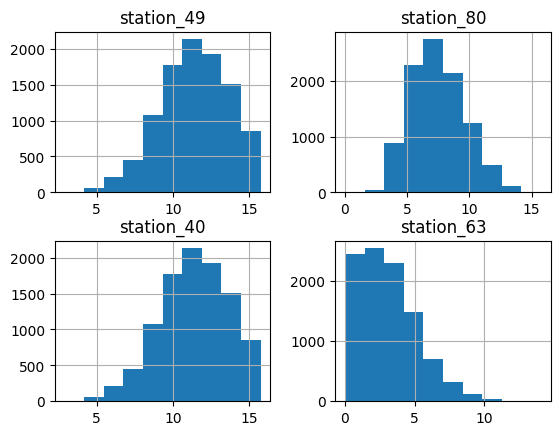

In [10]:
Y.hist()

##  Solution cours 1 pour générer

In [11]:
import numpy as np
from scipy import stats
import random
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import layers

import os
import time

import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from IPython.display import Image

from config.utils import *
print("TF version: ", tf.__version__)

%load_ext autoreload
%autoreload 2

TF version:  2.15.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


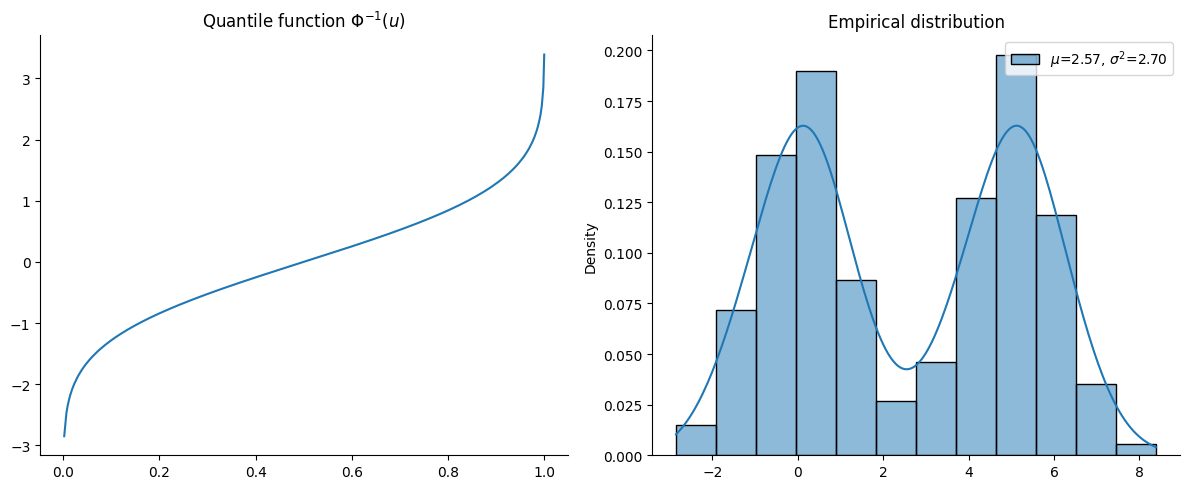

In [22]:
# data information
np.random.seed(1234)
N_DATA = 1000
DATA_DIM = 1

# Draw N_DATA uniform data in dimension DATA_DIM
#uniform = np.random.uniform(size=(N_DATA, DATA_DIM))
uniform = np.random.uniform(size=(int(N_DATA/2), DATA_DIM))

# Transform them to iid Gaussian random vairable by appying the inverse of the cdf available in scipy
#dataset_train = stats.norm.ppf(uniform).astype(np.float32)
dataset_train = np.concatenate([stats.norm.ppf(uniform).astype(np.float32), 
                                stats.norm.ppf(uniform, loc=5).astype(np.float32)])





# The function viz_gaussian_train has been imported from the file config.utils.py.
# It allows to display the function stats.norm.ppf and the empirical distribution
viz_gaussian_train(uniform, dataset_train)

## Generator

In [13]:
def build_generator(latent_dim, n_neurons, data_dim=DATA_DIM):
    """
    Build the Generator
    
    Parameters
    ----------
    latent_dim: int
        Latent dimension
    n_neurons: int
        Number of neurons in the hidden layer
    data_dim: int
        Data dimension

    Returns
    -------
    tf.Model
        GAN Generator
    """    
    model = tf.keras.Sequential(name="Generator")
    model.add(layers.Dense(n_neurons, input_shape=(latent_dim,), bias_initializer="glorot_normal"))
    
    # We use here an activation function LeakyReLU
    # Feel free to test other activavtion functions (ReLU, eLU, ...)
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Dense(data_dim, bias_initializer="glorot_normal"))
    return model

G_test = build_generator(latent_dim=1, n_neurons=10)
G_test.summary() 

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                20        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31 (124.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Discriminator

In [14]:
def build_discriminator(n_neurons, data_dim=DATA_DIM):
    """
    Build the discriminator
    
    Parameters
    ----------
    n_neurons: int
        Number of neurons in the hidden layer
    data_dim: int
        Data dimension

    Returns
    -------
    tf.Model
        GAN Discriminator
    """
    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Dense(n_neurons, input_shape=(DATA_DIM,), 
                           bias_initializer="glorot_normal", 
                           kernel_initializer="glorot_normal"))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    ####################################################
    # TO COMPLETE:
    # 1/ add another hidden layer with the same previous configuration (nb of neurons, activation function)
    model.add(layers.Dense(n_neurons, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    #2/ add the output layer (without a sigmoid function)
    model.add(layers.Dense(1, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
    ####################################################
    return model

D_test = build_discriminator(n_neurons=10)
D_test.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                20        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 141 (564.00 Byte)
Trainable params: 141 (564.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Define the loss functions
The optimization program writes as

\begin{align*}
&\mbox{$\theta$ fixed: } \quad \max_\phi \mathbb E_{x\sim p_r}\left[\log D_\phi(x) \right] + \mathbb E_{z\sim p_Z}\left[\log \left(1 - D_\phi \left(G_\theta(z) \right)\right) \right] 
\\
&\mbox{$\phi$ fixed: } \quad \max_\theta \mathbb E_{z\sim p_Z}\left[ \log\left(D_\phi\left( G_\theta(z)\right) \right) \right]
\end{align*}

**Remark:** The optimization algorithms in Tensorflow are by default minimizers.

In [15]:
def discriminator_loss(real_output, fake_output): 
    """
    Discriminator loss function

    Parameters
    ----------
    real_output: arr
        Discriminator outputs D(x)
    fake_output: arr
        Generator outputs D(G(z))

    Returns
    -------
    float
        Average of loss functions in the batch
    """
    ##########################
    # TO COMPLETE:
    # first line of the optimization program
    ##########################
    return -tf.reduce_mean(tf.math.log(tf.nn.sigmoid(real_output)) + tf.math.log(1-tf.nn.sigmoid(fake_output)))
  
def generator_loss(fake_output):
    """
    Generator loss function

    Parameters
    ----------
    fake_output: arr
        Generator outputs D(G(z))

    Returns
    -------
    float
        Average of loss functions in the batch
    """
    ##########################
    # TO COMPLETE:
    # second line of the optimization program
    ##########################
    return -tf.reduce_mean(tf.math.log(tf.nn.sigmoid(fake_output) ))

## Define the training function

<font color ="red"> **Always run this cell before the training loop !**

In [16]:
tf.random.set_seed(1234)
np.random.seed(1234)

# Training parameters:
# -------------------
EPOCHS =  100 # one forward/backward pass in all training samples
BATCH_SIZE = 32  # Number of training sample in one forward/backward pass
LATENT_DIM = 10
NEURONS_G = 100
NEURONS_D = 100
# -------------------

# Neural networks in the GAN
generator = build_generator(LATENT_DIM, NEURONS_G)
discriminator = build_discriminator(NEURONS_D)

# Optimizers
generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

# pour l'affichage
list_loss_G_train=[]
list_loss_D_train=[]

# ===========================================================================
# ===========================================================================
@tf.function
def train_step(data_batch, noise_dim):
    """
    Compute the gradient and update the parameters at each iteration

    Parameters
    ----------
    data_batch: arr
        Data batch (x_1, ..., x_m)
    noise_dim: int
        Latent dimension
    """
    
    batch_size = data_batch.shape[0]
    
    # Discriminator training
    noise = tf.random.uniform([batch_size, noise_dim])  # z = (z_1, .., z_m)
    with tf.GradientTape() as disc_tape:
        generated_data = generator(noise)  # G(z)  
        real_output = discriminator(data_batch)  # D(x)
        fake_output = discriminator(generated_data)  # D(G(z))

        disc_loss = discriminator_loss(real_output, fake_output)  # compute discriminator loss
    
    # compute the gradient
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # update the paramters
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        
    # Generator training
    #############
    # To complete
    # based on the discriminator training above
    #############
        
    noise = tf.random.uniform([batch_size, noise_dim]) # z = (z_1, .., z_m)
    with tf.GradientTape() as gen_tape:
        generated_data = generator(noise)  # G(z) 
        fake_output = discriminator(generated_data)  # D(G(z))
        
        gen_loss = generator_loss(fake_output)  # compute the generator loss
    
    # compute the gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # update the parameters
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return

def evaluate(data, noise_test):
    """
    Loss evaluation
    
    Parameters
    ----------
    data: arr
        Données de taille n, x=(x_1,..., x_n)
    noise_test: arr
        Bruit de taille n, z=(z_1,..., z_n)
        
    Returns
    -------
    loss_G: float
        Generator loss value
    loss_D: float
        Discriminator loss value
    """
    
    generated_data = generator(noise_test)
    real_output = discriminator(data)
    fake_output = discriminator(generated_data)
    
    loss_D = discriminator_loss(real_output, fake_output)
    loss_G = generator_loss(fake_output)

    return loss_G.numpy(), loss_D.numpy()

**Visualization before training**

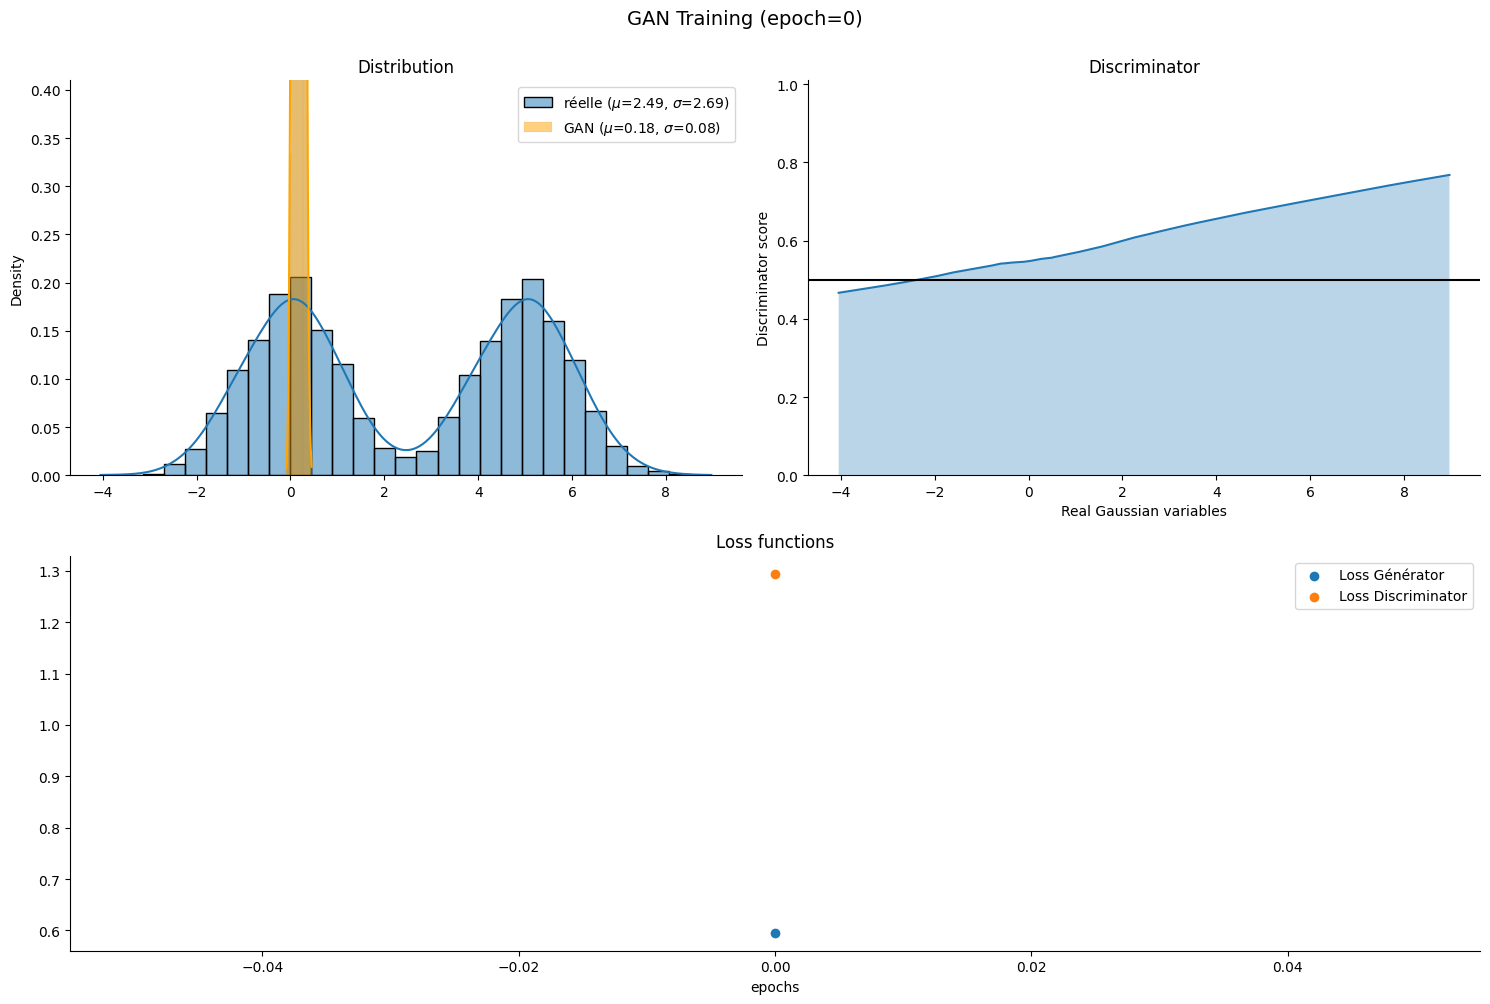

In [17]:
np.random.seed(1234)
noise_test = np.random.uniform(size=(N_DATA, LATENT_DIM))

# evaluation on all data with a fixed test noise
loss_G, loss_D = evaluate(dataset_train, noise_test)  
list_loss_G_train.append(loss_G)
list_loss_D_train.append(loss_D)

# visualization
viz_gaussian_gan(noise_test, dataset_train, generator, discriminator, list_loss_G_train, list_loss_D_train, epoch=0)

**Training**



Epoch 100 (0.62 sec): Loss Generator=0.754, Loss Discriminator=1.336


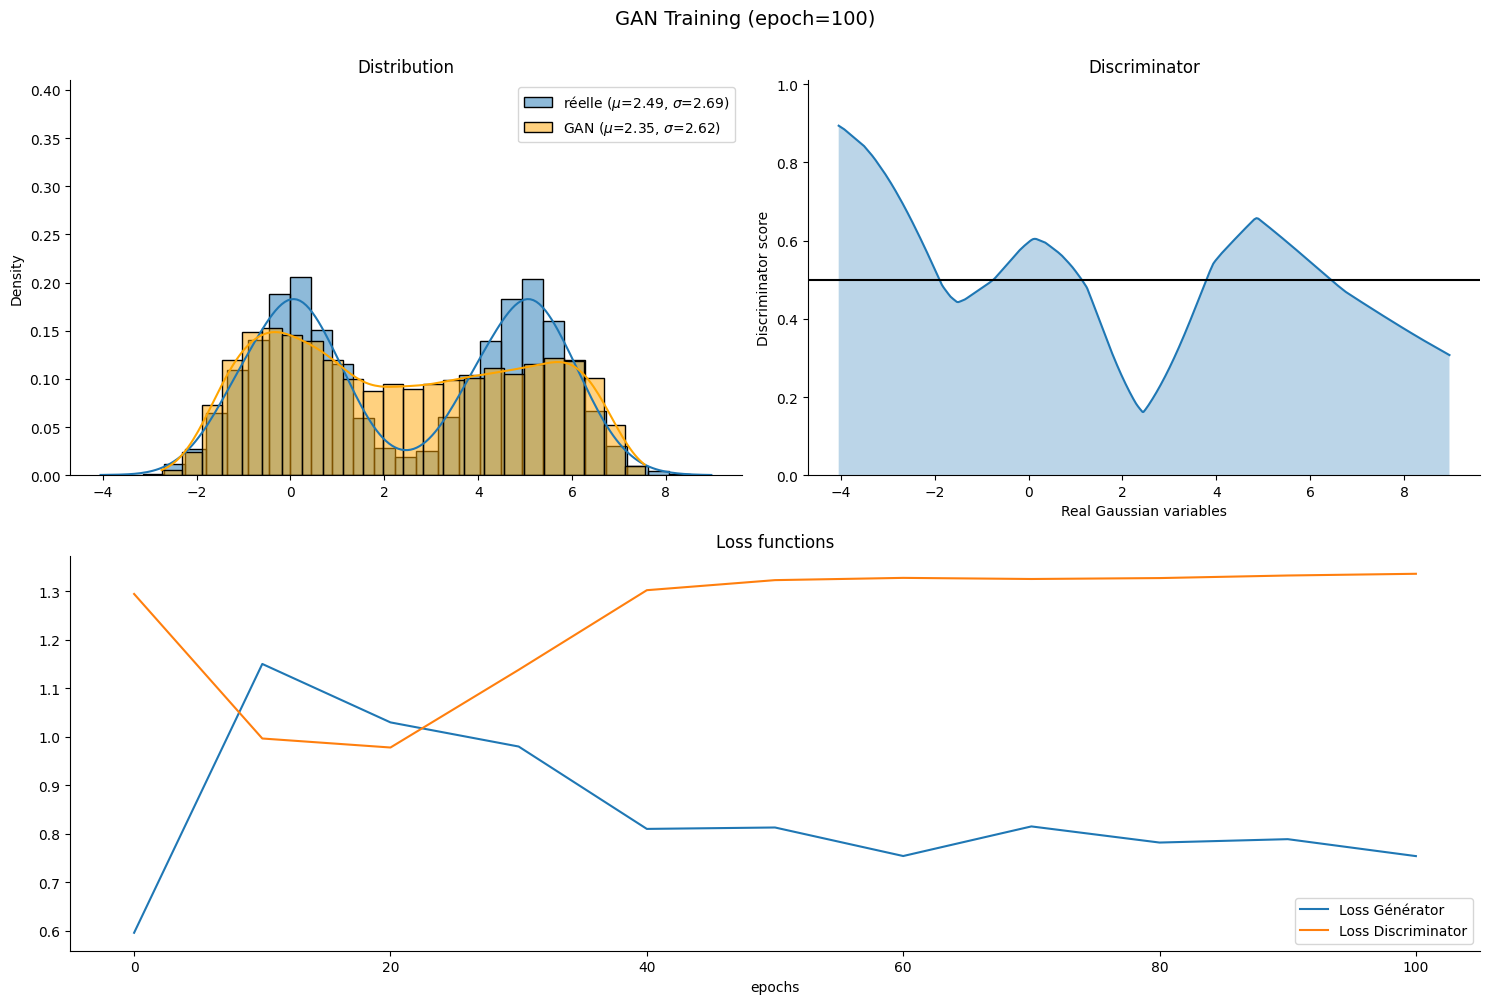

End of training.


In [18]:
# Training loop:
print("Start of training ...")
tf.random.set_seed(1234)

# split the data in batchs of with a size BATCH_SIZE and shuffle the data
data_batches = tf.data.Dataset.from_tensor_slices(dataset_train).shuffle(N_DATA).batch(BATCH_SIZE)

for epoch in range(1, EPOCHS+1):
    start_time= time.time()
    
    for data_batch in data_batches:
        train_step(data_batch, LATENT_DIM)
    
    if (epoch) % 10 == 0:    
        # evaluation with a fixed noise test
        loss_G, loss_D = evaluate(dataset_train, noise_test)  
        list_loss_G_train.append(loss_G)
        list_loss_D_train.append(loss_D)
        
        time_epoch = time.time() - start_time
        display.clear_output(wait=True)
        print("Epoch {} ({:.2f} sec): Loss Generator={:.3f}, Loss Discriminator={:.3f}".format(\
            epoch, time_epoch, loss_G, loss_D))

        viz_gaussian_gan(noise_test, dataset_train, generator, discriminator, 
                         list_loss_G_train, list_loss_D_train, epoch)

        plt.show()
         
print("End of training.")

## TIM VAE

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

import ot

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims, input_dims):  
        super(VariationalEncoder, self).__init__()

        self.latent_dims = min(latent_dims, 50)

        self.fc1 = nn.Linear(input_dims, 32)
        self.fc2 = nn.Linear(32, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, self.latent_dims)
        self.fc6 = nn.Linear(64, self.latent_dims)

        self.N = torch.distributions.Normal(0, 1) # Try a prior which is a mixture of gaussians?
        self.kl = 0

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        mu = self.fc5(x)
        sigma = torch.exp(self.fc6(x))
        N = self.N.sample(mu.shape)
        z = mu + sigma * N
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class VariationalDecoder(nn.Module):
    def __init__(self, latent_dims, output_dims):
        super(VariationalDecoder, self).__init__()

        self.latent_dims = min(latent_dims, 50)
        
        self.fc1 = nn.Linear(latent_dims, 64)
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, output_dims)
        
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = F.relu(self.fc5(z))
        return z
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, input_dims, output_dims, verbose):
        super(VariationalAutoencoder, self).__init__()
        self.verbose = verbose
        self.encoder = VariationalEncoder(latent_dims, input_dims)
        self.decoder = VariationalDecoder(latent_dims, output_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
### Training function
def train_vae(vae, X_train, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    batch = 25
    train_loss = 0.0
    verbose = vae.verbose
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for i in range(0, len(X_train), batch):
        batch_X = X_train[i:i+batch].float()
        
        x_hat = vae(batch_X)

        # Evaluate loss
        loss = ((batch_X - x_hat)**2).sum() + vae.encoder.kl
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0 and verbose:
            # Print batch loss
            print('[%i] \t partial train loss (single batch): %f' % (i, loss.item()))

        train_loss += loss.item()

    return train_loss / len(X_train)


### Testing function
def test_vae(vae, X_test):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0

    with torch.no_grad(): # No need to track the gradients
        for i in range(len(X_test)):
            x = X_test[i].clone().detach().float()
            
            # Decode data
            x_test = x.unsqueeze(0)
            x_hat = vae(x_test)

            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(X_test)


yields_df = pd.read_csv('CSVs/yields_subset.csv').iloc[:, 2:]
yields_tensor = torch.tensor(yields_df.values)

verbose = True
epochs = 200
lr = 1e-3
latent_dims = 40

vae = VariationalAutoencoder(latent_dims=latent_dims, input_dims=4, output_dims=4, verbose=verbose)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr) #, weight_decay=1e-5)

# Train
# ----------------------------------------------------------
for epoch in range(epochs):
    train_loss = train_vae(vae,yields_tensor,optimizer)
    torch.cuda.empty_cache()
    if epoch % 10 == 0 and verbose:
        print('\n EPOCH {}/{} \t train loss {:.3f}'.format(epoch + 1, epochs,train_loss))

# GENERATION
# Import noise array
noise = np.load('data/noise.npy')[:, :latent_dims]
indx_range = np.arange(0, len(noise))
indx_selected = np.random.choice(indx_range, size=1000, replace=False)
noise = torch.from_numpy(noise[indx_selected])

# Load the model
generator = vae.decoder
generator.eval()

# Generate the distribution
yields_gen_tensor = generator(noise)
yields_gen_numpy = yields_gen_tensor.detach().numpy()

yields_gen_df = pd.DataFrame(yields_gen_numpy, columns=["YIELD_1", "YIELD_2", "YIELD_3", "YIELD_4"])

print(ot.sliced.sliced_wasserstein_distance(yields_df.to_numpy(), yields_gen_df.to_numpy(), seed=0))

# Save the DataFrame to a CSV file
yields_gen_df.to_csv('CSVs/vae_yields_subset.csv', index=False)

ModuleNotFoundError: No module named 'torch'